In [2]:
import sys, os, subprocess
import warnings

import numpy as np
import h5py
import yaml

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

from ssd.net import build_ssd
from tqdm import tqdm
from utils import *

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torch.autograd import Variable
from ssd.layers.functions import PriorBox
from ssd.layers.modules import MultiBoxLoss
from ssd.net import build_ssd
from torch.cuda.amp import GradScaler, autocast

warnings.filterwarnings(
    action='ignore',
    category=UserWarning,
    module=r'.*'
)

plt.style.use('plots/ssdjet.mplstyle')

In [3]:
# parameters
events = h5py.File("/home/lavezzo/ssd_data/h5/SUEPPhysicsSSD_0.h5", 'r')
modelPath = 'models/{}.pth'.format('feb1_v3')
nEvents = 20
THRESHOLD = 0.2

In [4]:
# load network
config = yaml.safe_load(open('ssd-config.yml'))
net_config = yaml.safe_load(open('net-config.yml'))
dataset = config['dataset']['train'][0]
evaluation_pref = config['evaluation_pref']
ssd_settings = config['ssd_settings']
net_channels = net_config['network_channels']
batch_size = evaluation_pref['batch_size']
jet_names = evaluation_pref['names_classes']
num_workers = evaluation_pref['workers']
conf_threshold = ssd_settings['confidence_threshold']
input_dimensions = ssd_settings['input_dimensions']
jet_size = ssd_settings['object_size']
num_classes = ssd_settings['n_classes']
ssd_settings['n_classes'] += 1
max_distance = ssd_settings['max_distance']

loader = get_data_loader(dataset,
                             nEvents,
                             num_workers,
                             input_dimensions,
                             jet_size,
                             cpu=False,
                             return_baseline=False,
                             return_pt=True,
                             shuffle=False)

In [5]:
y, y_truth = next(iter(loader))

In [6]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
net = build_ssd(0, ssd_settings, net_channels, inference=True)
net.load_weights(modelPath)
cudnn.benchmark = True
net = net.cuda()
net.eval()

rank = 0

priors = Variable(PriorBox().apply(
        {'min_dim': ssd_settings['input_dimensions'][1:],
         'feature_maps': ssd_settings['feature_maps'],
         'steps': ssd_settings['steps'],
         'size': ssd_settings['object_size']}, rank))
criterion = MultiBoxLoss(rank,
                         priors,
                         ssd_settings['n_classes'],
                         min_overlap=ssd_settings['overlap_threshold'])

In [7]:
with torch.no_grad():
    y_pred = net(y)
    
    batch_detections = []
        
    for i in range(len(y)):
            
        event_detections = None
        detections, targets = y_pred[i], y[i]
        #scaler = scalers[i]
        scaler = 1
        
        for cid, dts in enumerate(detections):
            
            # Filter detections above given threshold
            dts = dts[dts[:, 0] > conf_threshold]
            
            if dts.size(0) == 0:
                continue
                
            dx = (dts[:, 1] + dts[:, 3]).unsqueeze(1)/2
            dy = (dts[:, 2] + dts[:, 4]).unsqueeze(1)/2
            scores = dts[:, 0].unsqueeze(1)
            regres = dts[:, 5].unsqueeze(1) * scaler
            labels = cid*torch.ones(len(scores)).unsqueeze(1)
            truths = torch.zeros(len(scores)).unsqueeze(1)
                        
            # Format: [x, y, label, score, pt]
            dts = torch.cat((dx, dy, labels, scores, regres), 1)  
                        
            # sort by confidence
            dts = dts[(-dts[:, 3]).argsort()]
            
            if event_detections is None: 
                event_detections = dts
            else: 
                event_detections = torch.cat((event_detections, dts))
            
        batch_detections.append(event_detections)

In [8]:
# Collect data
pts = events['PFCand_PT'][:nEvents]
phis = events['PFCand_Phi'][:nEvents]
etas = events['PFCand_Eta'][:nEvents]
labels = [events['labels'][i].reshape(-1,5) for i in range(nEvents)]
jet_eta =  [events['labels'][i].reshape(-1,5)[:,1] for i in range(nEvents)]
jet_phi =  [events['labels'][i].reshape(-1,5)[:,2] for i in range(nEvents)]
jet_pt =  [events['labels'][i].reshape(-1,5)[:,3] for i in range(nEvents)]
jet_mass =  [events['labels'][i].reshape(-1,5)[:,4] for i in range(nEvents)]
is_suep =  [events['labels'][i].reshape(-1,5)[:,0] for i in range(nEvents)]

In [9]:
# edges
edges_eta = np.linspace(0,280,281)
edges_phi = np.linspace(0,360,361)

In [10]:
def get_energy_map(etas, phis, values):
    """Translate eta/phi to pixel coordinates"""
    
    img, _, _ = np.histogram2d(etas,
                               phis,
                               bins=[edges_eta, edges_phi],
                               weights=values)
    bins = np.argwhere(img)
    indices_eta = bins[:, 0]
    indices_phi = bins[:, 1]
    values = img[indices_eta, indices_phi]
    return indices_eta, indices_phi, values, img

In [11]:
def get_jet_labels(etas, phis, pts, mass):
    """Returns labels for jets"""
    coordinates = []
    for e, p, pt,m in zip(etas, phis, pts, mass):
        x = np.argmax(edges_eta >= e)
        y = np.argmax(edges_phi >= p)
        coordinates.append([x, y, pt, m])
    return coordinates

def get_pred_jet_labels(preds):
    """Returns labels for predicted jets"""
    # Format: [x, y, label, score, truth, pt]
    coordinates = []
    for pred in preds:
        x = pred[0] * 280
        y = pred[1] * 360
        label = int(pred[2]%2)
        score = pred[3]
        pt = pred[4]
                
        x = np.argmax(edges_eta >= x)
        y = np.argmax(edges_phi >= y)
        
        coordinates.append([x, y, label, score, pt])
    return coordinates

In [12]:
def show_image(deposits, true_jets, pred_jets):
    """Draws event in color"""
    offset = 15
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()
    ax.set_xlim([-offset, deposits.shape[1]+offset])
    ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
    ax.set_ylim([-offset, deposits.shape[0]+offset])
    ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)
    ax.imshow(deposits)

    for j in true_jets:
        
        suep = j[-1]
        if suep:
            s = patches.Rectangle((j[0]-23, j[1]-23),
                                   46,
                                   46,
                                   linewidth=2,
                                   edgecolor='red',
                                   facecolor='none')
            ax.add_patch(s)
            ax.text(j[0]-23, j[1]+23,
               'SUEP, m={:.1f}, pt={:.1f}'.format(j[-1],j[-2]),
               color='#FAFAFA',
               bbox={'facecolor': 'red', 'alpha': 1.0})
        else:
            s = patches.Rectangle((j[0]-23, j[1]-23),
                                   46,
                                   46,
                                   linewidth=2,
                                   edgecolor='white',
                                   facecolor='none')
            ax.add_patch(s)
            ax.text(j[0]-23, j[1]+23,
                'Jet, m={:.1f}, pt={:.1f}'.format(j[-1],j[-2]),
                color='black',
                bbox={'facecolor': 'white', 'alpha': 1.0})
            
    for j in pred_jets:
                    
        suep = j[2]
        if suep:
            s = patches.Rectangle((j[0]-23, j[1]-23),
                                   46,
                                   46,
                                   linewidth=2,
                                   edgecolor='magenta',
                                   facecolor='none')
            ax.add_patch(s)
            ax.text(j[0]-23, j[1]-35,
                'Pred. SUEP, pt={:.1f}, c={:.1f}'.format(j[4],j[3]),
                color='#FAFAFA',
                bbox={'facecolor': 'magenta', 'alpha': 1.0})
        else:
            s = patches.Rectangle((j[0]-23, j[1]-23),
                                   46,
                                   46,
                                   linewidth=2,
                                   edgecolor='green',
                                   facecolor='none')
            ax.add_patch(s)
            ax.text(j[0]-23, j[1]-35,
                'Pred. Jet, pt={:.1f}, c={:.1f}'.format(j[4],j[3]),
                color='white',
                bbox={'facecolor': 'green', 'alpha': 1.0})

In [13]:
def plotEtaPhi(eta, phi, energy, visualizeEnergy):
    '''
        Helper function to plot the points in the (\eta,\phi) plane.
        The points belonging to the same class (SUEP, QCD) are colored with the same color.
        eta : Points \eta 
        phi : Points \phi positions 
        energy: Points Energies 
        visualizeEnergy: Marker size proportional to point energy, bool
    '''
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    ax.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
    ax.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)
    ax.scatter(eta, phi, s = energy*10,  color='cornflowerblue', alpha = .5 ) 

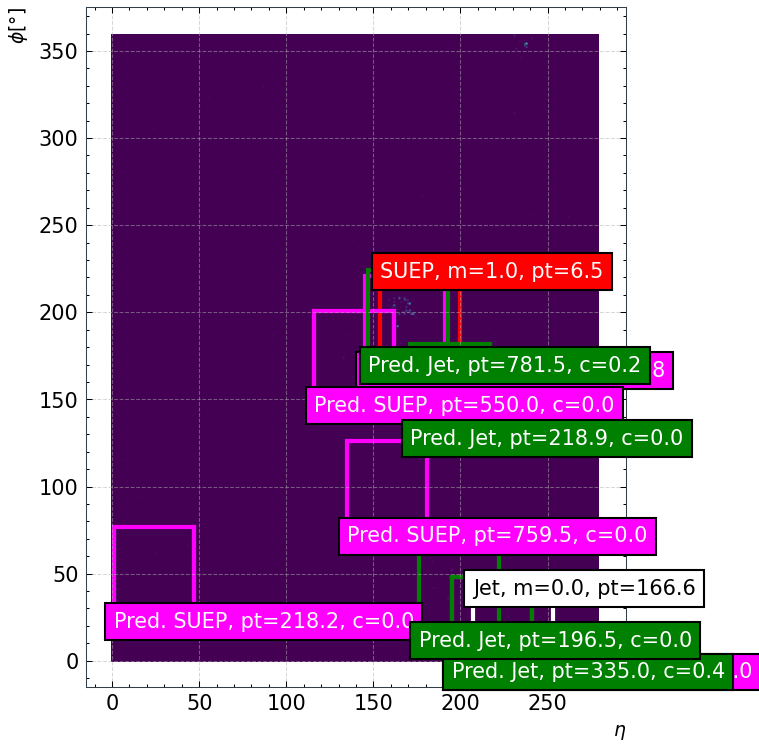

In [25]:
THRESHOLD = 0.015

for i in range(nEvents):
    if i != 4: continue

    # energy map
    xeta, xphi, _, img = get_energy_map(etas[i], phis[i], pts[i])
    
    # get scaler for predicted pTs
    scaler = max(pts[i])

    # set class labels, get labels for true jets
    class_labels = [int(b) for b in (is_suep[i]) % 2]
    true_jets = get_jet_labels(jet_eta[i], jet_phi[i], jet_pt[i], jet_mass[i])
    for jet, c in zip(true_jets, class_labels): jet.append(c)
    
    # get labels for predicted jets, select only above confident threshold
    pred_jets = get_pred_jet_labels(batch_detections[i].cpu().tolist())
    
    # x y label score pt
    pred_jets = [j for j in pred_jets if j[-2] > THRESHOLD]
    for j in range(len(pred_jets)): 
        pred_jets[j][-1] =  pred_jets[j][-1]*scaler

    # Visualize the event
    # plotEtaPhi(etas[i], phis[i], pts[i], True)
    
    # Final image with labels    
    show_image(img.T, true_jets, pred_jets)